Cross-Validation (accuracy): 0.68 ± 0.00

Accuracy: 0.56
F1-Score (weighted): 0.50

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.29      0.36       428
           2       0.20      0.06      0.10       249
           3       0.60      0.85      0.70       811

    accuracy                           0.56      1488
   macro avg       0.42      0.40      0.39      1488
weighted avg       0.50      0.56      0.50      1488



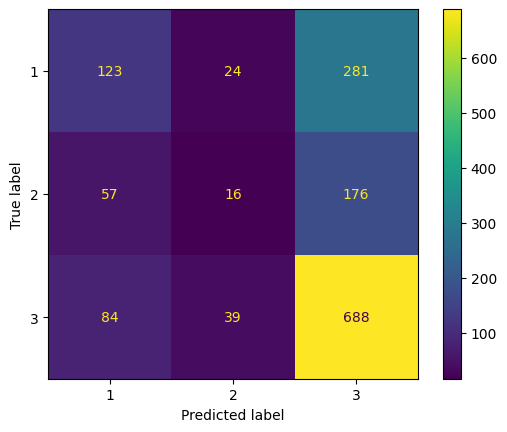

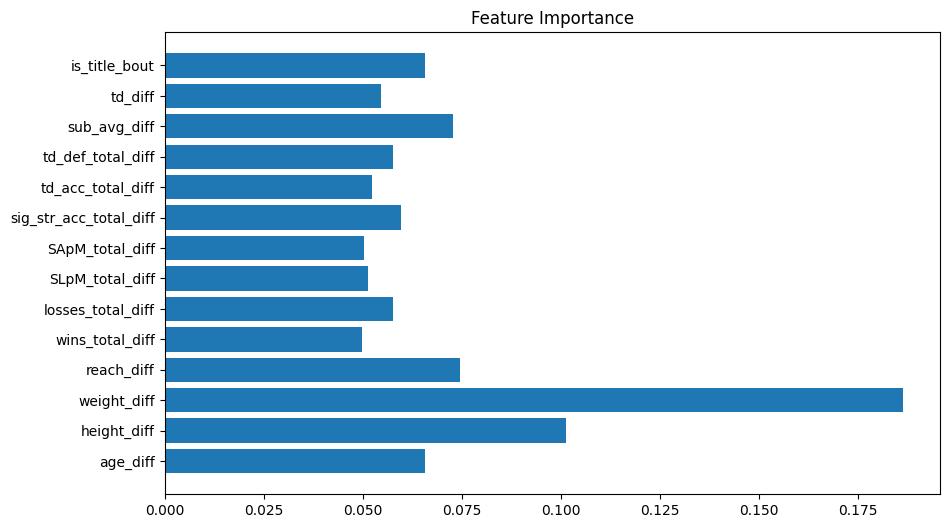


Predicted round for the fight: 3


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1. Load the data
ufc_data = pd.read_csv('../data/processed/ufc_data_final.csv')

# 2. Ask the user to define if it's a title fight or not
is_title_bout_manual = int(input("Is this a title bout? Enter 1 for YES or 0 for NO: "))

# Data preparation
# Calculate feature differences
ufc_data['age_diff'] = ufc_data['r_age'] - ufc_data['b_age']
ufc_data['height_diff'] = ufc_data['r_height'] - ufc_data['b_height']
ufc_data['weight_diff'] = ufc_data['r_weight'] - ufc_data['b_weight']
ufc_data['reach_diff'] = ufc_data['r_reach'] - ufc_data['b_reach']
ufc_data['wins_total_diff'] = ufc_data['r_wins_total'] - ufc_data['b_wins_total']
ufc_data['losses_total_diff'] = ufc_data['r_losses_total'] - ufc_data['b_losses_total']
ufc_data['SLpM_total_diff'] = ufc_data['r_SLpM_total'] - ufc_data['b_SLpM_total']
ufc_data['SApM_total_diff'] = ufc_data['r_SApM_total'] - ufc_data['b_SApM_total']
ufc_data['sig_str_acc_total_diff'] = ufc_data['r_sig_str_acc_total'] - ufc_data['b_sig_str_acc_total']
ufc_data['td_acc_total_diff'] = ufc_data['r_td_acc_total'] - ufc_data['b_td_acc_total']
ufc_data['td_def_total_diff'] = ufc_data['r_td_def_total'] - ufc_data['b_td_def_total']
ufc_data['sub_avg_diff'] = ufc_data['r_sub_avg'] - ufc_data['b_sub_avg']
ufc_data['td_diff'] = ufc_data['r_td_avg'] - ufc_data['b_td_avg']

# Adjust labels based on user input
ufc_data['adjusted_finish_round'] = ufc_data.apply(
    lambda row: row['finish_round'] if is_title_bout_manual == 1 else min(row['finish_round'], 3),
    axis=1
)

# Exclude features related to rounds 4 and 5 for non-title fights
if is_title_bout_manual == 0:
    ufc_data = ufc_data[ufc_data['adjusted_finish_round'] <= 3]

# Define features and target
features = [
    'age_diff', 'height_diff', 'weight_diff', 'reach_diff',
    'wins_total_diff', 'losses_total_diff', 'SLpM_total_diff',
    'SApM_total_diff', 'sig_str_acc_total_diff', 'td_acc_total_diff',
    'td_def_total_diff', 'sub_avg_diff', 'td_diff', 'is_title_bout'
]
X = ufc_data[features]
y = ufc_data['adjusted_finish_round']

# Drop missing values
X = X.dropna()
y = y[X.index]

# Adjust labels for XGBoost (start from 0)
y_adjusted = y - 1

# Normalize features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_adjusted, test_size=0.2, random_state=42, stratify=y_adjusted)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 3. Train the model
model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
print(f"Cross-Validation (accuracy): {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# 4. Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nAccuracy: {accuracy:.2f}")
print(f"F1-Score (weighted): {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test + 1, y_pred + 1))  # Return labels to original scale

# Confusion matrix
cm = confusion_matrix(y_test + 1, y_pred + 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()

# Feature importance
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.title("Feature Importance")
plt.show()

# 5. Prediction for specific fighters
fighter_1 = "Shara Magomedov"
fighter_2 = "Armen Petrosyan"

fighter_1_data = ufc_data[ufc_data['r_fighter'] == fighter_1].iloc[0]
fighter_2_data = ufc_data[ufc_data['b_fighter'] == fighter_2].iloc[0]

input_data = pd.DataFrame([{
    'age_diff': fighter_1_data['r_age'] - fighter_2_data['b_age'],
    'height_diff': fighter_1_data['r_height'] - fighter_2_data['b_height'],
    'weight_diff': fighter_1_data['r_weight'] - fighter_2_data['b_weight'],
    'reach_diff': fighter_1_data['r_reach'] - fighter_2_data['b_reach'],
    'wins_total_diff': fighter_1_data['r_wins_total'] - fighter_2_data['b_wins_total'],
    'losses_total_diff': fighter_1_data['r_losses_total'] - fighter_2_data['b_losses_total'],
    'SLpM_total_diff': fighter_1_data['r_SLpM_total'] - fighter_2_data['b_SLpM_total'],
    'SApM_total_diff': fighter_1_data['r_SApM_total'] - fighter_2_data['b_SApM_total'],
    'sig_str_acc_total_diff': fighter_1_data['r_sig_str_acc_total'] - fighter_2_data['b_sig_str_acc_total'],
    'td_acc_total_diff': fighter_1_data['r_td_acc_total'] - fighter_2_data['b_td_acc_total'],
    'td_def_total_diff': fighter_1_data['r_td_def_total'] - fighter_2_data['b_td_def_total'],
    'sub_avg_diff': fighter_1_data['r_sub_avg'] - fighter_2_data['b_sub_avg'],
    'td_diff': fighter_1_data['r_td_avg'] - fighter_2_data['b_td_avg'],
    'is_title_bout': is_title_bout_manual
}])

# Normalize input data
input_data_scaled = scaler.transform(input_data)

# Predict the round
predicted_round = model.predict(input_data_scaled) + 1
print(f"\nPredicted round for the fight: {predicted_round[0]}")



Accuracy: 0.68
F1-Score (weighted): 0.69
Recall (weighted): 0.68
Cohen's Kappa: 0.49
ROC-AUC: 0.83
Class 1: Precision = 0.69, Recall = 0.82, F1-Score = 0.75
Class 2: Precision = 0.35, Recall = 0.46, F1-Score = 0.40
Class 3: Precision = 0.84, Recall = 0.68, F1-Score = 0.75


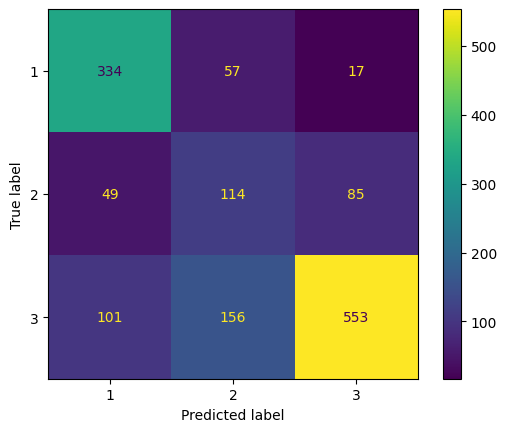

                    Feature  Importance
16  avg_fight_duration_diff    0.120760
13       activity_rate_diff    0.068883
22                 b_td_acc    0.065748
14    str_success_rate_diff    0.060551
21                 r_td_acc    0.057943
17         strike_rate_diff    0.046870
28          b_str_def_total    0.031030
30           b_td_def_total    0.027332
12                  td_diff    0.027303
34                 b_td_avg    0.027187
27          r_str_def_total    0.025753
31                r_sub_avg    0.024595
24      b_sig_str_acc_total    0.024022
7           SApM_total_diff    0.023865
6           SLpM_total_diff    0.023810
11             sub_avg_diff    0.023417
29           r_td_def_total    0.023355
10        td_def_total_diff    0.022509
33                 r_td_avg    0.022364
26           b_td_acc_total    0.022072
15         recent_wins_diff    0.021702
9         td_acc_total_diff    0.021181
8    sig_str_acc_total_diff    0.020380
4           wins_total_diff    0.019840


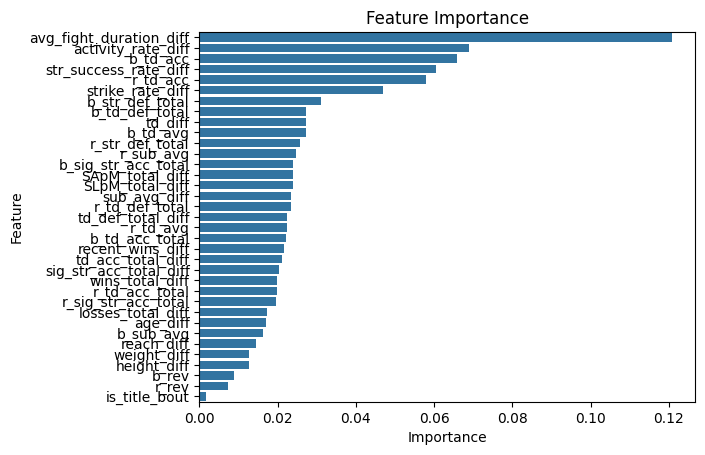


Predicted round for the fight: 2

Probability of each round:
Round 1: 37.16%
Round 2: 37.97%
Round 3: 24.87%

Precision: 0.72
Recall: 0.68

Detailed Classification Report for Prediction:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       408
           1       0.35      0.46      0.40       248
           2       0.84      0.68      0.75       810

    accuracy                           0.68      1466
   macro avg       0.63      0.65      0.63      1466
weighted avg       0.72      0.68      0.69      1466



In [59]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, roc_auc_score, precision_score, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
ufc_data = pd.read_csv('../data/processed/ufc_data_final.csv')

# 2. Ask the user to define if it's a title fight or not
is_title_bout_manual = int(input("Is this a title bout? Enter 1 for YES or 0 for NO: "))

# Data preparation
# Calculate feature differences
ufc_data['age_diff'] = ufc_data['r_age'] - ufc_data['b_age']
ufc_data['height_diff'] = ufc_data['r_height'] - ufc_data['b_height']
ufc_data['weight_diff'] = ufc_data['r_weight'] - ufc_data['b_weight']
ufc_data['reach_diff'] = ufc_data['r_reach'] - ufc_data['b_reach']
ufc_data['wins_total_diff'] = ufc_data['r_wins_total'] - ufc_data['b_wins_total']
ufc_data['losses_total_diff'] = ufc_data['r_losses_total'] - ufc_data['b_losses_total']
ufc_data['SLpM_total_diff'] = ufc_data['r_SLpM_total'] - ufc_data['b_SLpM_total']
ufc_data['SApM_total_diff'] = ufc_data['r_SApM_total'] - ufc_data['b_SApM_total']
ufc_data['sig_str_acc_total_diff'] = ufc_data['r_sig_str_acc_total'] - ufc_data['b_sig_str_acc_total']
ufc_data['td_acc_total_diff'] = ufc_data['r_td_acc_total'] - ufc_data['b_td_acc_total']
ufc_data['td_def_total_diff'] = ufc_data['r_td_def_total'] - ufc_data['b_td_def_total']
ufc_data['sub_avg_diff'] = ufc_data['r_sub_avg'] - ufc_data['b_sub_avg']
ufc_data['td_diff'] = ufc_data['r_td_avg'] - ufc_data['b_td_avg']

# Add new calculated features
ufc_data['r_activity_rate'] = ufc_data['r_str_att'] / ufc_data['time_sec']
ufc_data['b_activity_rate'] = ufc_data['b_str_att'] / ufc_data['time_sec']
ufc_data['activity_rate_diff'] = ufc_data['r_activity_rate'] - ufc_data['b_activity_rate']

ufc_data['r_str_success_rate'] = ufc_data['r_str'] / ufc_data['r_str_att']
ufc_data['b_str_success_rate'] = ufc_data['b_str'] / ufc_data['b_str_att']
ufc_data['str_success_rate_diff'] = ufc_data['r_str_success_rate'] - ufc_data['b_str_success_rate']

# Additional features
ufc_data['r_recent_wins'] = ufc_data['r_wins_total'] / (ufc_data['r_wins_total'] + ufc_data['r_losses_total'])
ufc_data['b_recent_wins'] = ufc_data['b_wins_total'] / (ufc_data['b_wins_total'] + ufc_data['b_losses_total'])
ufc_data['recent_wins_diff'] = ufc_data['r_recent_wins'] - ufc_data['b_recent_wins']

ufc_data['r_avg_fight_duration'] = ufc_data['r_ctrl_sec'] / ufc_data['r_wins_total']
ufc_data['b_avg_fight_duration'] = ufc_data['b_ctrl_sec'] / ufc_data['b_wins_total']
ufc_data['avg_fight_duration_diff'] = ufc_data['r_avg_fight_duration'] - ufc_data['b_avg_fight_duration']

ufc_data['r_strike_rate'] = ufc_data['r_sig_str'] / ufc_data['time_sec']
ufc_data['b_strike_rate'] = ufc_data['b_sig_str'] / ufc_data['time_sec']
ufc_data['strike_rate_diff'] = ufc_data['r_strike_rate'] - ufc_data['b_strike_rate']

# Adjust labels based on user input
ufc_data['adjusted_finish_round'] = ufc_data.apply(
    lambda row: row['finish_round'] if is_title_bout_manual == 1 else min(row['finish_round'], 3),
    axis=1
)

# Exclude features related to rounds 4 and 5 for non-title fights
if is_title_bout_manual == 0:
    ufc_data = ufc_data[ufc_data['adjusted_finish_round'] <= 3]
additional_features = [
    'r_rev', 'b_rev', 'r_td_acc', 'b_td_acc',
    'r_sig_str_acc_total', 'b_sig_str_acc_total',
    'r_td_acc_total', 'b_td_acc_total',
    'r_str_def_total', 'b_str_def_total',
    'r_td_def_total', 'b_td_def_total',
    'r_sub_avg', 'b_sub_avg', 'r_td_avg', 'b_td_avg'
]

# Define features and target
features = [
    'age_diff', 'height_diff', 'weight_diff', 'reach_diff',
    'wins_total_diff', 'losses_total_diff', 'SLpM_total_diff',
    'SApM_total_diff', 'sig_str_acc_total_diff', 'td_acc_total_diff',
    'td_def_total_diff', 'sub_avg_diff', 'td_diff',
    'activity_rate_diff', 'str_success_rate_diff', 'recent_wins_diff',
    'avg_fight_duration_diff', 'strike_rate_diff', 'is_title_bout'
] + additional_features

X = ufc_data[features]
y = ufc_data['adjusted_finish_round']

# Drop missing values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Align y with the filtered X
# Adjust labels for classification (start from 0)
y_adjusted = y - 1

# Normalize features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.replace([np.inf, -np.inf], np.nan).dropna()), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_adjusted, test_size=0.2, random_state=42, stratify=y_adjusted)

# 3. Train the Balanced Random Forest model
model = BalancedRandomForestClassifier(
    n_estimators=1000, max_depth=10, random_state=42, 
    sampling_strategy='auto', replacement=False, bootstrap=True
)
model.fit(X_train, y_train)

# 4. Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.2f}")
print(f"F1-Score (weighted): {f1:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Detailed classification report
class_report = classification_report(y_test + 1, y_pred + 1, output_dict=True)
for class_label, metrics in class_report.items():
    if class_label not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"Class {class_label}: Precision = {metrics['precision']:.2f}, Recall = {metrics['recall']:.2f}, F1-Score = {metrics['f1-score']:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test + 1, y_pred + 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.show()

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance")
plt.show()

# Save results for a new prediction
fighter_1 = "Khamzat Chimaev"
fighter_2 = "Robert Whittaker"

# Check if fighters exist in the dataset
fighter_1_data = ufc_data[ufc_data['r_fighter'] == fighter_1]
fighter_2_data = ufc_data[ufc_data['b_fighter'] == fighter_2]

if fighter_1_data.empty:
    print(f"Error: Fighter '{fighter_1}' not found in the dataset.")
    exit()
if fighter_2_data.empty:
    print(f"Error: Fighter '{fighter_2}' not found in the dataset.")
    exit()

# Extract first occurrence of data
fighter_1_data = fighter_1_data.iloc[0]
fighter_2_data = fighter_2_data.iloc[0]

input_data = pd.DataFrame([{
    'age_diff': fighter_1_data['r_age'] - fighter_2_data['b_age'],
    'height_diff': fighter_1_data['r_height'] - fighter_2_data['b_height'],
    'weight_diff': fighter_1_data['r_weight'] - fighter_2_data['b_weight'],
    'reach_diff': fighter_1_data['r_reach'] - fighter_2_data['b_reach'],
    'wins_total_diff': fighter_1_data['r_wins_total'] - fighter_2_data['b_wins_total'],
    'losses_total_diff': fighter_1_data['r_losses_total'] - fighter_2_data['b_losses_total'],
    'SLpM_total_diff': fighter_1_data['r_SLpM_total'] - fighter_2_data['b_SLpM_total'],
    'SApM_total_diff': fighter_1_data['r_SApM_total'] - fighter_2_data['b_SApM_total'],
    'sig_str_acc_total_diff': fighter_1_data['r_sig_str_acc_total'] - fighter_2_data['b_sig_str_acc_total'],
    'td_acc_total_diff': fighter_1_data['r_td_acc_total'] - fighter_2_data['b_td_acc_total'],
    'td_def_total_diff': fighter_1_data['r_td_def_total'] - fighter_2_data['b_td_def_total'],
    'sub_avg_diff': fighter_1_data['r_sub_avg'] - fighter_2_data['b_sub_avg'],
    'td_diff': fighter_1_data['r_td_avg'] - fighter_2_data['b_td_avg'],
    'activity_rate_diff': fighter_1_data['r_activity_rate'] - fighter_2_data['b_activity_rate'],
    'str_success_rate_diff': fighter_1_data['r_str_success_rate'] - fighter_2_data['b_str_success_rate'],
    'recent_wins_diff': fighter_1_data['r_recent_wins'] - fighter_2_data['b_recent_wins'],
    'avg_fight_duration_diff': fighter_1_data['r_avg_fight_duration'] - fighter_2_data['b_avg_fight_duration'],
    'strike_rate_diff': fighter_1_data['r_strike_rate'] - fighter_2_data['b_strike_rate'],
    'rev_diff': fighter_1_data['r_rev'] - fighter_2_data['b_rev'],
    'td_acc_diff': fighter_1_data['r_td_acc'] - fighter_2_data['b_td_acc'],
    'sig_str_acc_diff': fighter_1_data['r_sig_str_acc_total'] - fighter_2_data['b_sig_str_acc_total'],
    'td_total_diff': fighter_1_data['r_td_acc_total'] - fighter_2_data['b_td_acc_total'],
    'str_def_diff': fighter_1_data['r_str_def_total'] - fighter_2_data['b_str_def_total'],
    'td_def_diff': fighter_1_data['r_td_def_total'] - fighter_2_data['b_td_def_total'],
    'td_avg_diff': fighter_1_data['r_td_avg'] - fighter_2_data['b_td_avg'],
    'is_title_bout': is_title_bout_manual
}])

# Ensure input_data columns match the training feature set
input_data = input_data.reindex(columns=X.columns)

# Convert to float to match training data type
input_data = input_data.astype(float)

# Normalize input data
input_data_scaled = pd.DataFrame(scaler.transform(input_data), columns=X.columns)

# Predict the round
predicted_round = model.predict(input_data_scaled) + 1
predicted_proba = model.predict_proba(input_data_scaled)

# Output predicted round and probabilities
print(f"\nPredicted round for the fight: {predicted_round[0]}")
print("\nProbability of each round:")
for i, prob in enumerate(predicted_proba[0], 1):
    print(f"Round {i}: {prob * 100:.2f}%")

# Additional metrics for input prediction
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_individual = classification_report(y_test, y_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\nDetailed Classification Report for Prediction:")
print(f1_individual)



Accuracy: 0.45
F1-Score (weighted): 0.49
Cohen's Kappa: 0.26
ROC-AUC: 0.70

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       408
           1       0.33      0.14      0.19       248
           2       0.73      0.41      0.52       747
           3       0.02      0.62      0.03         8
           4       0.10      0.31      0.15        55

    accuracy                           0.45      1466
   macro avg       0.36      0.44      0.31      1466
weighted avg       0.60      0.45      0.49      1466



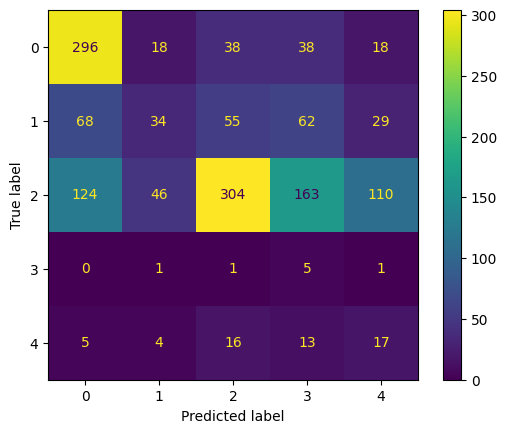


Detailed Metrics for Each Class:
Class 0:
  Precision: 0.60
  Recall: 0.73
  F1-Score: 0.66
Class 1:
  Precision: 0.33
  Recall: 0.14
  F1-Score: 0.19
Class 2:
  Precision: 0.73
  Recall: 0.41
  F1-Score: 0.52
Class 3:
  Precision: 0.02
  Recall: 0.62
  F1-Score: 0.03
Class 4:
  Precision: 0.10
  Recall: 0.31
  F1-Score: 0.15


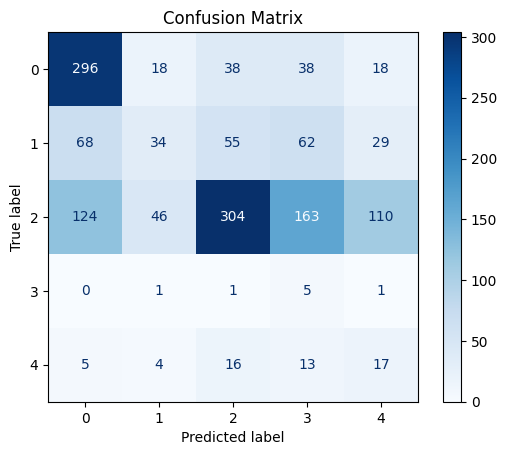

In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, roc_auc_score
)
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
ufc_data = pd.read_csv('../data/processed/ufc_data_final.csv')

# Data preparation
# Calculate feature differences
ufc_data['age_diff'] = ufc_data['r_age'] - ufc_data['b_age']
ufc_data['height_diff'] = ufc_data['r_height'] - ufc_data['b_height']
ufc_data['weight_diff'] = ufc_data['r_weight'] - ufc_data['b_weight']
ufc_data['reach_diff'] = ufc_data['r_reach'] - ufc_data['b_reach']
ufc_data['wins_total_diff'] = ufc_data['r_wins_total'] - ufc_data['b_wins_total']
ufc_data['losses_total_diff'] = ufc_data['r_losses_total'] - ufc_data['b_losses_total']
ufc_data['SLpM_total_diff'] = ufc_data['r_SLpM_total'] - ufc_data['b_SLpM_total']
ufc_data['SApM_total_diff'] = ufc_data['r_SApM_total'] - ufc_data['b_SApM_total']
ufc_data['sig_str_acc_total_diff'] = ufc_data['r_sig_str_acc_total'] - ufc_data['b_sig_str_acc_total']
ufc_data['td_acc_total_diff'] = ufc_data['r_td_acc_total'] - ufc_data['b_td_acc_total']
ufc_data['td_def_total_diff'] = ufc_data['r_td_def_total'] - ufc_data['b_td_def_total']
ufc_data['sub_avg_diff'] = ufc_data['r_sub_avg'] - ufc_data['b_sub_avg']
ufc_data['td_diff'] = ufc_data['r_td_avg'] - ufc_data['b_td_avg']

ufc_data['r_activity_rate'] = ufc_data['r_str_att'] / ufc_data['time_sec']
ufc_data['b_activity_rate'] = ufc_data['b_str_att'] / ufc_data['time_sec']
ufc_data['activity_rate_diff'] = ufc_data['r_activity_rate'] - ufc_data['b_activity_rate']

ufc_data['r_str_success_rate'] = ufc_data['r_str'] / ufc_data['r_str_att']
ufc_data['b_str_success_rate'] = ufc_data['b_str'] / ufc_data['b_str_att']
ufc_data['str_success_rate_diff'] = ufc_data['r_str_success_rate'] - ufc_data['b_str_success_rate']

ufc_data['recent_wins_diff'] = (
    ufc_data['r_wins_total'] / (ufc_data['r_wins_total'] + ufc_data['r_losses_total'])
    - ufc_data['b_wins_total'] / (ufc_data['b_wins_total'] + ufc_data['b_losses_total'])
)

ufc_data['avg_fight_duration_diff'] = (
    ufc_data['r_ctrl_sec'] / ufc_data['r_wins_total']
    - ufc_data['b_ctrl_sec'] / ufc_data['b_wins_total']
)

ufc_data['strike_rate_diff'] = ufc_data['r_sig_str'] / ufc_data['time_sec'] - ufc_data['b_sig_str'] / ufc_data['time_sec']

# Define features and target
features = [
    'age_diff', 'height_diff', 'weight_diff', 'reach_diff',
    'wins_total_diff', 'losses_total_diff', 'SLpM_total_diff',
    'SApM_total_diff', 'sig_str_acc_total_diff', 'td_acc_total_diff',
    'td_def_total_diff', 'sub_avg_diff', 'td_diff',
    'activity_rate_diff', 'str_success_rate_diff', 'recent_wins_diff',
    'avg_fight_duration_diff', 'strike_rate_diff'
]
X = ufc_data[features]
y = ufc_data['finish_round'] - 1  # Adjust labels to start from 0

# Drop missing values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Align y with the filtered X

# Normalize features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the Balanced Random Forest model
model = BalancedRandomForestClassifier(
    n_estimators=1000, max_depth=10, random_state=42, 
    sampling_strategy='auto', replacement=False, bootstrap=True
)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nAccuracy: {accuracy:.2f}")
print(f"F1-Score (weighted): {f1:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.show()
# Detailed metrics for each class
class_report = classification_report(y_test, y_pred, output_dict=True)

print("\nDetailed Metrics for Each Class:")
for class_label, metrics in class_report.items():
    if class_label not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"Class {class_label}:")
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-Score: {metrics['f1-score']:.2f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()




=== Random Forest Model ===
Accuracy: 0.73
F1-Score: 0.78
Precision: 0.82
Recall: 0.74
              precision    recall  f1-score   support

   Blue Wins       0.59      0.69      0.64       517
    Red Wins       0.82      0.74      0.78       971

    accuracy                           0.73      1488
   macro avg       0.70      0.72      0.71      1488
weighted avg       0.74      0.73      0.73      1488



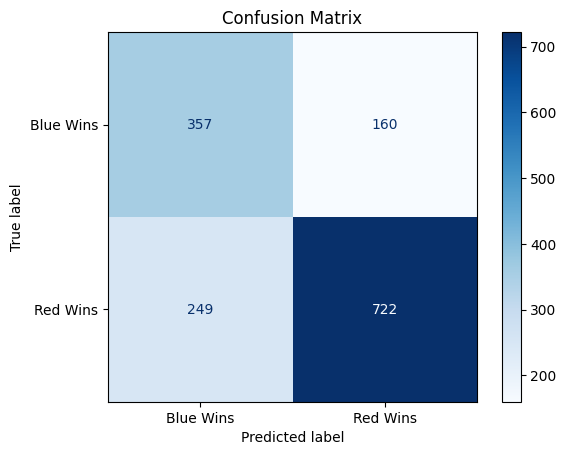

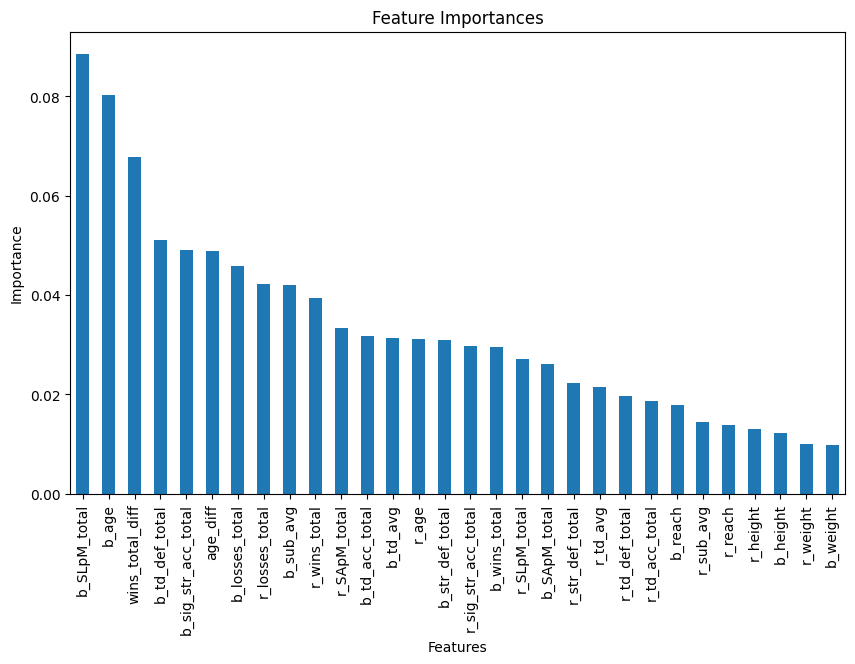


=== Cross-Validation Results ===
Accuracy: 0.73 (± 0.02)
Precision: 0.75 (± 0.03)
Recall: 0.89 (± 0.07)
F1: 0.81 (± 0.01)

=== Predicted Class Probabilities ===
Blue Wins: 43.27%
Red Wins: 56.73%
Random Forest модель сохранена в '../models/random_forest_model.pkl'


In [70]:
# Импортируем необходимые библиотеки
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib

# Загрузка данных
ufc_data_cleaned = pd.read_csv('../data/processed/ufc_data_final.csv')

# Кодирование целевой переменной
ufc_data_cleaned['red_wins'] = (ufc_data_cleaned['winner'] == 'Red').astype(int)

features = [
    'r_age', 'b_age',
    'r_height', 'b_height',
    'r_weight', 'b_weight',
    'r_reach', 'b_reach',
    'r_wins_total', 'b_wins_total',
    'r_losses_total', 'b_losses_total',
    'r_SLpM_total', 'b_SLpM_total',
    'r_SApM_total', 'b_SApM_total',
    'r_sig_str_acc_total', 'b_sig_str_acc_total',
    'r_td_acc_total', 'b_td_acc_total',
    'r_td_def_total', 'b_td_def_total',
    'r_sub_avg', 'b_sub_avg',
    'r_td_avg', 'b_td_avg', 'r_str_def_total', 'b_str_def_total', 'wins_total_diff','age_diff'
]

X = ufc_data_cleaned[features]
y = ufc_data_cleaned['red_wins']

# Обработка пропущенных значений
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Функция для оценки модели
def evaluate_model(model, X_train, y_train, X_test, y_test, title="Model Evaluation"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Вывод результатов
    print(f"\n=== {title} ===")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(classification_report(y_test, y_pred, target_names=["Blue Wins", "Red Wins"]))

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Blue Wins", "Red Wins"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, f1, precision, recall

# Создание и оценка модели Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=1000,  # Количество деревьев
    max_depth=10,       # Максимальная глубина деревьев
    random_state=42    # Фиксация результата
)

accuracy, f1, precision, recall = evaluate_model(
    random_forest_model, X_train_resampled, y_train_resampled, X_test, y_test, title="Random Forest Model"
)

# Важность признаков
feature_importances = pd.Series(random_forest_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), title='Feature Importances')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Кросс-валидация
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(random_forest_model, X, y, cv=10, scoring=scoring, return_train_score=False)

# Вывод результатов кросс-валидации
print("\n=== Cross-Validation Results ===")
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.capitalize()}: {mean_score:.2f} (± {std_score:.2f})")

# Предсказание классов и вероятностей
random_forest_model.fit(X_train_resampled, y_train_resampled)
y_pred_proba = random_forest_model.predict_proba(X_test)
predicted_percentages = y_pred_proba.mean(axis=0) * 100

print("\n=== Predicted Class Probabilities ===")
print(f"Blue Wins: {predicted_percentages[0]:.2f}%")
print(f"Red Wins: {predicted_percentages[1]:.2f}%")

# Сохранение модели
joblib.dump(random_forest_model, "../models/sportynetai_10_depth_random_forest_model_v1.1000.pkl")
print("Random Forest модель сохранена в '../models/random_forest_model.pkl'")


In [20]:
# Сохранение модели
joblib.dump(random_forest_model, "../models/random_forest_model.pkl")
print("Random Forest модель сохранена в '../models/random_forest_model.pkl'")

Random Forest модель сохранена в '../models/random_forest_model.pkl'


In [5]:
import pandas as pd
import joblib

def find_fighter_data(fighter_name, dataset):
    """
    Find fighter's data in the dataset.
    """
    fighter_name_clean = fighter_name.strip().lower()
    red_fighters = dataset['r_fighter'].str.strip().str.lower()
    blue_fighters = dataset['b_fighter'].str.strip().str.lower()

    if fighter_name_clean in red_fighters.values:
        data = dataset[red_fighters == fighter_name_clean].iloc[0].to_dict()
        return pd.DataFrame([data]), 'Red Corner'
    elif fighter_name_clean in blue_fighters.values:
        data = dataset[blue_fighters == fighter_name_clean].iloc[0].to_dict()
        return pd.DataFrame([data]), 'Blue Corner'
    else:
        return None, None

def extract_metrics(fighter_data, corner):
    """
    Extract metrics dynamically based on the corner.
    """
    prefix = 'r_' if corner == 'Red Corner' else 'b_'
    return [
        fighter_data.iloc[0][f'{prefix}age'],
        fighter_data.iloc[0][f'{prefix}height'],
        fighter_data.iloc[0][f'{prefix}weight'],
        fighter_data.iloc[0][f'{prefix}reach'],
        fighter_data.iloc[0][f'{prefix}wins_total'],
        fighter_data.iloc[0][f'{prefix}losses_total'],
        fighter_data.iloc[0][f'{prefix}SLpM_total'],
        fighter_data.iloc[0][f'{prefix}SApM_total'],
        fighter_data.iloc[0][f'{prefix}sig_str_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_def_total'],
        fighter_data.iloc[0][f'{prefix}sub_avg'],
        fighter_data.iloc[0][f'{prefix}td_avg'],
        fighter_data.iloc[0][f'{prefix}str_def_total']
    ]

def normalize_fighter_order(fighter1_name, fighter2_name):
    """
    Normalize the fighter order to ensure consistent assignment of corners.
    Always assign the alphabetically first name to the Red Corner.
    """
    fighter1_clean = fighter1_name.strip().lower()
    fighter2_clean = fighter2_name.strip().lower()

    if fighter1_clean < fighter2_clean:
        return fighter1_name, fighter2_name  # Fighter1 is Red, Fighter2 is Blue
    else:
        return fighter2_name, fighter1_name  # Fighter2 is Red, Fighter1 is Blue

def main():
    print("UFC Fight Prediction Program")

    # Hardcoded paths for model and dataset
    model_path = "../models/sportynetai_7_depth_random_forest_model_v1.pkl"  # Path to your trained model
    dataset_path = "../data/processed/ufc_data_final.csv"  # Path to your dataset

    # Load the model
    try:
        loaded_model = joblib.load(model_path)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Load the dataset
    try:
        ufc_dataset = pd.read_csv(dataset_path)
        print("Dataset loaded successfully!")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Input fighter names
    fighter1_name = "Joe Solecki"  # Replace with actual fighter name
    fighter2_name = "Nurullo Aliev"  # Replace with actual fighter name

    # Normalize fighter order
    red_corner_fighter, blue_corner_fighter = normalize_fighter_order(fighter1_name, fighter2_name)

    # Fetch data for the normalized fighters
    red_fighter_data, red_fighter_corner = find_fighter_data(red_corner_fighter, ufc_dataset)
    blue_fighter_data, blue_fighter_corner = find_fighter_data(blue_corner_fighter, ufc_dataset)

    if red_fighter_data is None:
        print(f"Error: Fighter '{red_corner_fighter}' not found in the dataset.")
        return
    if blue_fighter_data is None:
        print(f"Error: Fighter '{blue_corner_fighter}' not found in the dataset.")
        return

    # Extract metrics dynamically
    red_fighter_values = extract_metrics(red_fighter_data, 'Red Corner')
    blue_fighter_values = extract_metrics(blue_fighter_data, 'Blue Corner')

    # Output corner information
    print(f"\nFighter '{red_corner_fighter}' normalized to: Red Corner")
    print(f"Fighter '{blue_corner_fighter}' normalized to: Blue Corner")

    # Output metrics for analysis
    metrics = ['Age', 'Height', 'Weight', 'Reach', 'Wins Total', 'Losses Total']
    print("\nMetrics Comparison:")
    print(f"{'Metric':<15} {'Red Corner (Fighter 1)':<20} {'Blue Corner (Fighter 2)':<20} {'Difference':<10}")
    for i, metric in enumerate(metrics):
        diff = red_fighter_values[i] - blue_fighter_values[i]
        print(f"{metric:<15} {red_fighter_values[i]:<20} {blue_fighter_values[i]:<20} {diff:<10}")

    # Additional features
    age_diff = red_fighter_values[0] - blue_fighter_values[0]
    wins_total_diff = red_fighter_values[4] - blue_fighter_values[4]
    shared_features = [wins_total_diff, age_diff]

    # Prepare input for prediction
    input_data = pd.DataFrame([red_fighter_values + blue_fighter_values + shared_features], columns=[
        "r_age", "r_height", "r_weight", "r_reach", "r_wins_total", "r_losses_total",
        "r_SLpM_total", "r_SApM_total", "r_sig_str_acc_total", "r_td_acc_total",
        "r_td_def_total", "r_sub_avg", "r_td_avg", "r_str_def_total",
        "b_age", "b_height", "b_weight", "b_reach", "b_wins_total", "b_losses_total",
        "b_SLpM_total", "b_SApM_total", "b_sig_str_acc_total", "b_td_acc_total",
        "b_td_def_total", "b_sub_avg", "b_td_avg", "b_str_def_total", "age_diff", "wins_total_diff"
    ])

    # Prediction
    try:
        if hasattr(loaded_model, "feature_names_in_"):
            input_data = input_data[loaded_model.feature_names_in_]

        prediction = loaded_model.predict(input_data)
        probabilities = loaded_model.predict_proba(input_data)

        # Output prediction results
        winner = red_corner_fighter if prediction[0] == 1 else blue_corner_fighter
        winner_probability = max(probabilities[0]) * 100
        loser = blue_corner_fighter if prediction[0] == 1 else red_corner_fighter
        loser_probability = 100 - winner_probability

        print("\nPrediction Results:")
        print(f"Winner: {winner}")
        print(f"Winning Probability: {winner_probability:.2f}%")
        print(f"Loser: {loser}")
        print(f"Losing Probability: {loser_probability:.2f}%")
    except Exception as e:
        print(f"Error during prediction: {e}")

if __name__ == "__main__":
    main()


UFC Fight Prediction Program
Model loaded successfully!
Dataset loaded successfully!

Fighter 'Joe Solecki' normalized to: Red Corner
Fighter 'Nurullo Aliev' normalized to: Blue Corner

Metrics Comparison:
Metric          Red Corner (Fighter 1) Blue Corner (Fighter 2) Difference
Age             30.0                 23.0                 7.0       
Height          175.26               177.8                -2.5400000000000205
Weight          70.31                70.31                0.0       
Reach           177.8                182.88               -5.079999999999984
Wins Total      13                   9                    4         
Losses Total    4                    0                    4         

Prediction Results:
Winner: Joe Solecki
Winning Probability: 66.22%
Loser: Nurullo Aliev
Losing Probability: 33.78%


In [136]:
import pandas as pd
import joblib

def find_fighter_data(fighter_name, dataset):
    """
    Find fighter's data in the dataset.
    """
    fighter_name_clean = fighter_name.strip().lower()
    red_fighters = dataset['r_fighter'].str.strip().str.lower()
    blue_fighters = dataset['b_fighter'].str.strip().str.lower()

    if fighter_name_clean in red_fighters.values:
        data = dataset[red_fighters == fighter_name_clean].iloc[0].to_dict()
        return pd.DataFrame([data]), 'Red Corner'
    elif fighter_name_clean in blue_fighters.values:
        data = dataset[blue_fighters == fighter_name_clean].iloc[0].to_dict()
        return pd.DataFrame([data]), 'Blue Corner'
    else:
        return None, None

def extract_metrics(fighter_data, corner):
    """
    Extract metrics dynamically based on the corner.
    """
    prefix = 'r_' if corner == 'Red Corner' else 'b_'
    return [
        fighter_data.iloc[0][f'{prefix}age'],
        fighter_data.iloc[0][f'{prefix}height'],
        fighter_data.iloc[0][f'{prefix}weight'],
        fighter_data.iloc[0][f'{prefix}reach'],
        fighter_data.iloc[0][f'{prefix}wins_total'],
        fighter_data.iloc[0][f'{prefix}losses_total'],
        fighter_data.iloc[0][f'{prefix}SLpM_total'],
        fighter_data.iloc[0][f'{prefix}SApM_total'],
        fighter_data.iloc[0][f'{prefix}sig_str_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_def_total'],
        fighter_data.iloc[0][f'{prefix}sub_avg'],
        fighter_data.iloc[0][f'{prefix}td_avg'],
        fighter_data.iloc[0][f'{prefix}str_def_total']
    ]

def main():
    print("UFC Fight Prediction Program")

    # Hardcoded paths for model and dataset
    model_path = "../models/sportynetai_5_depth_v1.pkl"  # Path to your trained model
    dataset_path = "../data/processed/ufc_data_final.csv"  # Path to your dataset

    # Load the model
    try:
        loaded_model = joblib.load(model_path)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Load the dataset
    try:
        ufc_dataset = pd.read_csv(dataset_path)
        print("Dataset loaded successfully!")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Hardcoded fighter names
    fighter2_name = "Ilia Topuria"  # Replace with actual fighter name
    fighter1_name = "Belal Muhammad"  # Replace with actual fighter name

    # Fetch fighter data
    fighter1_data, fighter1_corner = find_fighter_data(fighter1_name, ufc_dataset)
    fighter2_data, fighter2_corner = find_fighter_data(fighter2_name, ufc_dataset)

    if fighter1_data is None:
        print(f"Error: Fighter '{fighter1_name}' not found in the dataset.")
        return
    if fighter2_data is None:
        print(f"Error: Fighter '{fighter2_name}' not found in the dataset.")
        return

    # Extract metrics dynamically
    fighter1_values = extract_metrics(fighter1_data, fighter1_corner)
    fighter2_values = extract_metrics(fighter2_data, fighter2_corner)

    # Output corner information
    print(f"\nFighter '{fighter1_name}' data taken from: {fighter1_corner}")
    print(f"Fighter '{fighter2_name}' data taken from: {fighter2_corner}")

    # Output metrics for analysis
    metrics = ['Age', 'Height', 'Weight', 'Reach', 'Wins Total', 'Losses Total']
    print("\nMetrics Comparison:")
    print(f"{'Metric':<15} {'Fighter 1':<20} {'Fighter 2':<20} {'Difference':<10}")
    for i, metric in enumerate(metrics):
        diff = fighter1_values[i] - fighter2_values[i]
        print(f"{metric:<15} {fighter1_values[i]:<20} {fighter2_values[i]:<20} {diff:<10}")

    # Additional features
    age_diff = fighter1_values[0] - fighter2_values[0]
    wins_total_diff = fighter1_values[4] - fighter2_values[4]
    shared_features = [wins_total_diff, age_diff]

    # Prepare input for prediction
    input_data = pd.DataFrame([fighter1_values + fighter2_values + shared_features], columns=[
        "r_age", "r_height", "r_weight", "r_reach", "r_wins_total", "r_losses_total",
        "r_SLpM_total", "r_SApM_total", "r_sig_str_acc_total", "r_td_acc_total",
        "r_td_def_total", "r_sub_avg", "r_td_avg","r_str_def_total",
        "b_age", "b_height", "b_weight", "b_reach", "b_wins_total", "b_losses_total",
        "b_SLpM_total", "b_SApM_total", "b_sig_str_acc_total", "b_td_acc_total",
        "b_td_def_total", "b_sub_avg", "b_td_avg","b_str_def_total", "age_diff", "wins_total_diff"
    ])

    # Prediction
    try:
        # Reorder input columns if needed
        if hasattr(loaded_model, "feature_names_in_"):
            input_data = input_data[loaded_model.feature_names_in_]

        prediction = loaded_model.predict(input_data)
        probabilities = loaded_model.predict_proba(input_data)

        # Output prediction results
        winner = fighter1_name if prediction[0] == 1 else fighter2_name
        winner_probability = max(probabilities[0]) * 100
        loser = fighter2_name if prediction[0] == 1 else fighter1_name
        loser_probability = 100 - winner_probability

        print("\nPrediction Results:")
        print(f"Winner: {winner}")
        print(f"Winning Probability: {winner_probability:.2f}%")
        print(f"Loser: {loser}")
        print(f"Losing Probability: {loser_probability:.2f}%")
    except Exception as e:
        print(f"Error during prediction: {e}")

if __name__ == "__main__":
    main()


UFC Fight Prediction Program
Model loaded successfully!
Dataset loaded successfully!

Fighter 'Belal Muhammad' data taken from: Red Corner
Fighter 'Gilbert Burns' data taken from: Red Corner

Metrics Comparison:
Metric          Fighter 1            Fighter 2            Difference
Age             35.0                 37.0                 -2.0      
Height          180.34               177.8                2.539999999999992
Weight          77.11                77.11                0.0       
Reach           182.88               180.34               2.539999999999992
Wins Total      23                   22                   1         
Losses Total    3                    7                    -4        

Prediction Results:
Winner: Gilbert Burns
Winning Probability: 83.60%
Loser: Belal Muhammad
Losing Probability: 16.40%


In [18]:
import pandas as pd
import joblib

def find_fighter_data(fighter_name, dataset):
    """
    Find fighter's data in the dataset, regardless of the corner.
    """
    fighter_name_clean = fighter_name.strip().lower()
    # Ищем бойца независимо от угла
    red_fighters = dataset['r_fighter'].str.strip().str.lower()
    blue_fighters = dataset['b_fighter'].str.strip().str.lower()

    if fighter_name_clean in red_fighters.values:
        data = dataset[red_fighters == fighter_name_clean].iloc[0].to_dict()
        return pd.DataFrame([data]), 'Red Corner'
    elif fighter_name_clean in blue_fighters.values:
        data = dataset[blue_fighters == fighter_name_clean].iloc[0].to_dict()
        return pd.DataFrame([data]), 'Blue Corner'
    else:
        return None, None

def extract_metrics(fighter_data, corner):
    """
    Extract metrics dynamically based on the corner.
    """
    if fighter_data is None:
        return [None] * 14

    prefix = 'r_' if corner == 'Red Corner' else 'b_'
    return [
        fighter_data.iloc[0][f'{prefix}age'],
        fighter_data.iloc[0][f'{prefix}height'],
        fighter_data.iloc[0][f'{prefix}weight'],
        fighter_data.iloc[0][f'{prefix}reach'],
        fighter_data.iloc[0][f'{prefix}wins_total'],
        fighter_data.iloc[0][f'{prefix}losses_total'],
        fighter_data.iloc[0][f'{prefix}SLpM_total'],
        fighter_data.iloc[0][f'{prefix}SApM_total'],
        fighter_data.iloc[0][f'{prefix}sig_str_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_def_total'],
        fighter_data.iloc[0][f'{prefix}sub_avg'],
        fighter_data.iloc[0][f'{prefix}td_avg'],
        fighter_data.iloc[0][f'{prefix}str_def_total']
    ]

def main():
    print("UFC Fight Prediction Program")

    # Hardcoded paths for model and dataset
    model_path = "../models/sportynetai_7_depth_random_forest_model_v1.pkl"  # Path to your trained model
    dataset_path = "../data/processed/ufc_data_final.csv"  # Path to your dataset

    # Load the model
    try:
        loaded_model = joblib.load(model_path)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Load the dataset
    try:
        ufc_dataset = pd.read_csv(dataset_path)
        print("Dataset loaded successfully!")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Input fighter names
    fighter1_name = "AMANDA RIBAS"  # Replace with actual fighter name
    fighter2_name = "MACKENZIE DERN"  # Replace with actual fighter name

    # Fetch data for the first fighter
    fighter1_data, fighter1_corner = find_fighter_data(fighter1_name, ufc_dataset)
    if fighter1_data is None:
        print(f"Error: Fighter '{fighter1_name}' not found in the dataset.")
        return

    # Fetch data for the second fighter
    fighter2_data, fighter2_corner = find_fighter_data(fighter2_name, ufc_dataset)
    if fighter2_data is None:
        print(f"Error: Fighter '{fighter2_name}' not found in the dataset.")
        return

    # Extract metrics dynamically
    fighter1_values = extract_metrics(fighter1_data, fighter1_corner)
    fighter2_values = extract_metrics(fighter2_data, fighter2_corner)

    # Output corner information
    print(f"\nFighter '{fighter1_name}' is in: {fighter1_corner}")
    print(f"Fighter '{fighter2_name}' is in: {fighter2_corner}")

    # Output metrics for analysis
    metrics = ['Age', 'Height', 'Weight', 'Reach', 'Wins Total', 'Losses Total']
    print("\nMetrics Comparison:")
    print(f"{'Metric':<15} {'Fighter 1':<20} {'Fighter 2':<20} {'Difference':<10}")
    for i, metric in enumerate(metrics):
        diff = (fighter1_values[i] if fighter1_values[i] is not None else 0) - \
               (fighter2_values[i] if fighter2_values[i] is not None else 0)
        print(f"{metric:<15} {fighter1_values[i]:<20} {fighter2_values[i]:<20} {diff:<10}")

    # Additional features
    age_diff = (fighter1_values[0] if fighter1_values[0] is not None else 0) - \
               (fighter2_values[0] if fighter2_values[0] is not None else 0)
    wins_total_diff = (fighter1_values[4] if fighter1_values[4] is not None else 0) - \
                      (fighter2_values[4] if fighter2_values[4] is not None else 0)
    shared_features = [wins_total_diff, age_diff]

    # Prepare input for prediction
    input_data = pd.DataFrame([fighter1_values + fighter2_values + shared_features], columns=[
        "r_age", "r_height", "r_weight", "r_reach", "r_wins_total", "r_losses_total",
        "r_SLpM_total", "r_SApM_total", "r_sig_str_acc_total", "r_td_acc_total",
        "r_td_def_total", "r_sub_avg", "r_td_avg", "r_str_def_total",
        "b_age", "b_height", "b_weight", "b_reach", "b_wins_total", "b_losses_total",
        "b_SLpM_total", "b_SApM_total", "b_sig_str_acc_total", "b_td_acc_total",
        "b_td_def_total", "b_sub_avg", "b_td_avg", "b_str_def_total", "age_diff", "wins_total_diff"
    ])

    # Prediction
    try:
        if hasattr(loaded_model, "feature_names_in_"):
            input_data = input_data[loaded_model.feature_names_in_]

        prediction = loaded_model.predict(input_data)
        probabilities = loaded_model.predict_proba(input_data)

        # Output prediction results
        winner = fighter1_name if prediction[0] == 1 else fighter2_name
        winner_probability = max(probabilities[0]) * 100
        loser = fighter2_name if prediction[0] == 1 else fighter1_name
        loser_probability = 100 - winner_probability

        print("\nPrediction Results:")
        print(f"Winner: {winner}")
        print(f"Winning Probability: {winner_probability:.2f}%")
        print(f"Loser: {loser}")
        print(f"Losing Probability: {loser_probability:.2f}%")
    except Exception as e:
        print(f"Error during prediction: {e}")

if __name__ == "__main__":
    main()


UFC Fight Prediction Program
Model loaded successfully!
Dataset loaded successfully!

Fighter 'AMANDA RIBAS' is in: Red Corner
Fighter 'MACKENZIE DERN' is in: Red Corner

Metrics Comparison:
Metric          Fighter 1            Fighter 2            Difference
Age             30.0                 31.0                 -1.0      
Height          160.02               162.56               -2.539999999999992
Weight          56.7                 52.16                4.540000000000006
Reach           167.64               160.02               7.619999999999976
Wins Total      12                   13                   -1        
Losses Total    5                    5                    0         

Prediction Results:
Winner: MACKENZIE DERN
Winning Probability: 58.31%
Loser: AMANDA RIBAS
Losing Probability: 41.69%


In [15]:
import pandas as pd
import joblib

def preprocess_data(dataset, fighter1_name, fighter2_name):
    """
    Preprocess the dataset to create a unified table with the same structure for both fighters.
    """
    fighter1_data = dataset[(dataset['r_fighter'].str.strip().str.lower() == fighter1_name.strip().lower()) |
                            (dataset['b_fighter'].str.strip().str.lower() == fighter1_name.strip().lower())]
    fighter2_data = dataset[(dataset['r_fighter'].str.strip().str.lower() == fighter2_name.strip().lower()) |
                            (dataset['b_fighter'].str.strip().str.lower() == fighter2_name.strip().lower())]

    if fighter1_data.empty or fighter2_data.empty:
        print(f"Error: Fighters '{fighter1_name}' or '{fighter2_name}' not found in the dataset.")
        return None, None

    fighter1_info = {
        'r_age': fighter1_data['r_age'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_age'].values[0],
        'r_height': fighter1_data['r_height'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_height'].values[0],
        'r_weight': fighter1_data['r_weight'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_weight'].values[0],
        'r_reach': fighter1_data['r_reach'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_reach'].values[0],
        'r_wins_total': fighter1_data['r_wins_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_wins_total'].values[0],
        'r_losses_total': fighter1_data['r_losses_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_losses_total'].values[0],
        'r_SLpM_total': fighter1_data['r_SLpM_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_SLpM_total'].values[0],
        'r_SApM_total': fighter1_data['r_SApM_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_SApM_total'].values[0],
        'r_sig_str_acc_total': fighter1_data['r_sig_str_acc_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_sig_str_acc_total'].values[0],
        'r_td_acc_total': fighter1_data['r_td_acc_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_td_acc_total'].values[0],
        'r_td_def_total': fighter1_data['r_td_def_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_td_def_total'].values[0],
        'r_sub_avg': fighter1_data['r_sub_avg'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_sub_avg'].values[0],
        'r_td_avg': fighter1_data['r_td_avg'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_td_avg'].values[0],
        'r_str_def_total': fighter1_data['r_str_def_total'].values[0] if fighter1_data['r_fighter'].str.strip().str.lower().eq(fighter1_name.strip().lower()).any() else fighter1_data['b_str_def_total'].values[0]
    }

    fighter2_info = {
        'b_age': fighter2_data['r_age'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_age'].values[0],
        'b_height': fighter2_data['r_height'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_height'].values[0],
        'b_weight': fighter2_data['r_weight'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_weight'].values[0],
        'b_reach': fighter2_data['r_reach'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_reach'].values[0],
        'b_wins_total': fighter2_data['r_wins_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_wins_total'].values[0],
        'b_losses_total': fighter2_data['r_losses_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_losses_total'].values[0],
        'b_SLpM_total': fighter2_data['r_SLpM_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_SLpM_total'].values[0],
        'b_SApM_total': fighter2_data['r_SApM_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_SApM_total'].values[0],
        'b_sig_str_acc_total': fighter2_data['r_sig_str_acc_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_sig_str_acc_total'].values[0],
        'b_td_acc_total': fighter2_data['r_td_acc_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_td_acc_total'].values[0],
        'b_td_def_total': fighter2_data['r_td_def_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_td_def_total'].values[0],
        'b_sub_avg': fighter2_data['r_sub_avg'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_sub_avg'].values[0],
        'b_td_avg': fighter2_data['r_td_avg'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_td_avg'].values[0],
        'b_str_def_total': fighter2_data['r_str_def_total'].values[0] if fighter2_data['r_fighter'].str.strip().str.lower().eq(fighter2_name.strip().lower()).any() else fighter2_data['b_str_def_total'].values[0]
    }

    fighter1_df = pd.DataFrame([fighter1_info])
    fighter2_df = pd.DataFrame([fighter2_info])

    wins_total_diff = fighter1_info['r_wins_total'] - fighter2_info['b_wins_total']
    age_diff = fighter1_info['r_age'] - fighter2_info['b_age']

    fighter1_df['wins_total_diff'] = wins_total_diff
    fighter1_df['age_diff'] = age_diff
    fighter2_df['wins_total_diff'] = wins_total_diff
    fighter2_df['age_diff'] = age_diff
    
    return fighter1_df, fighter2_df

def main():
    print("UFC Fight Prediction Program")

    model_path = "../models/sportynetai_7_depth_random_forest_model_v1.pkl"
    dataset_path = "../data/processed/ufc_data_final.csv"

    try:
        loaded_model = joblib.load(model_path)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    try:
        ufc_dataset = pd.read_csv(dataset_path)
        print("Dataset loaded successfully!")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    fighter1_name = "ISLAM MAKHACHEV"
    fighter2_name = "KHABIB NURMAGOMEDOV"

    fighter1_df, fighter2_df = preprocess_data(ufc_dataset, fighter1_name, fighter2_name)
    if fighter1_df is None or fighter2_df is None:
        return

    input_data = pd.concat([fighter1_df, fighter2_df], axis=1)
    print("Current input_data columns:")
    print(input_data.columns)

        # Удаляем дублирующие столбцы
    input_data = input_data.loc[:, ~input_data.columns.duplicated()]
    
    # Проверяем итоговые столбцы после удаления дубликатов
    print("Columns after removing duplicates:")
    print(input_data.columns)
    
    # Упорядочиваем столбцы в соответствии с expected_features
    if hasattr(loaded_model, "feature_names_in_"):
        expected_features = loaded_model.feature_names_in_
        print("Expected feature order:")
        print(expected_features)
    
        # Проверяем отсутствующие признаки
        missing_features = set(expected_features) - set(input_data.columns)
        if missing_features:
            print(f"Missing features: {missing_features}")
            return
    
        # Сортируем столбцы
        input_data = input_data[expected_features]
    
        # Проверяем порядок после сортировки
        print("Final input_data columns after sorting:")
        print(input_data.columns)
    
    # Выполняем предсказание
    try:
        prediction = loaded_model.predict(input_data)
        probabilities = loaded_model.predict_proba(input_data)
    
        # Определяем победителя и вероятность
        winner = fighter1_name if prediction[0] == 1 else fighter2_name
        winner_probability = max(probabilities[0]) * 100
        loser = fighter2_name if prediction[0] == 1 else fighter1_name
        loser_probability = 100 - winner_probability
    
        print("\nPrediction Results:")
        print(f"Winner: {winner}")
        print(f"Winning Probability: {winner_probability:.2f}%")
        print(f"Loser: {loser}")
        print(f"Losing Probability: {loser_probability:.2f}%")
    except Exception as e:
        print(f"Error during prediction: {e}")




if __name__ == "__main__":
    main()


UFC Fight Prediction Program
Model loaded successfully!
Dataset loaded successfully!
Current input_data columns:
Index(['r_age', 'r_height', 'r_weight', 'r_reach', 'r_wins_total',
       'r_losses_total', 'r_SLpM_total', 'r_SApM_total', 'r_sig_str_acc_total',
       'r_td_acc_total', 'r_td_def_total', 'r_sub_avg', 'r_td_avg',
       'r_str_def_total', 'wins_total_diff', 'age_diff', 'b_age', 'b_height',
       'b_weight', 'b_reach', 'b_wins_total', 'b_losses_total', 'b_SLpM_total',
       'b_SApM_total', 'b_sig_str_acc_total', 'b_td_acc_total',
       'b_td_def_total', 'b_sub_avg', 'b_td_avg', 'b_str_def_total',
       'wins_total_diff', 'age_diff'],
      dtype='object')
Columns after removing duplicates:
Index(['r_age', 'r_height', 'r_weight', 'r_reach', 'r_wins_total',
       'r_losses_total', 'r_SLpM_total', 'r_SApM_total', 'r_sig_str_acc_total',
       'r_td_acc_total', 'r_td_def_total', 'r_sub_avg', 'r_td_avg',
       'r_str_def_total', 'wins_total_diff', 'age_diff', 'b_age', 'b_h

In [58]:
import pandas as pd
import joblib

def find_fighter_data(fighter_name, dataset):
    """
    Find fighter's data in the dataset, regardless of the corner.
    """
    fighter_name_clean = fighter_name.strip().lower()
    red_fighters = dataset['r_fighter'].str.strip().str.lower()
    blue_fighters = dataset['b_fighter'].str.strip().str.lower()

    if fighter_name_clean in red_fighters.values:
        data = dataset[red_fighters == fighter_name_clean].iloc[0].to_dict()
        print(f"\nData for {fighter_name} found in Red Corner:")
        print(pd.DataFrame([data]))
        return pd.DataFrame([data]), 'Red Corner'
    elif fighter_name_clean in blue_fighters.values:
        data = dataset[blue_fighters == fighter_name_clean].iloc[0].to_dict()
        print(f"\nData for {fighter_name} found in Blue Corner:")
        print(pd.DataFrame([data]))
        return pd.DataFrame([data]), 'Blue Corner'
    else:
        print(f"\nError: Fighter '{fighter_name}' not found in dataset.")
        return None, None

def extract_metrics(fighter_data, corner):
    """
    Extract metrics dynamically based on the corner.
    """
    if fighter_data is None:
        return [None] * 14

    prefix = 'r_' if corner == 'Red Corner' else 'b_'
    return [
        fighter_data.iloc[0][f'{prefix}age'],
        fighter_data.iloc[0][f'{prefix}height'],
        fighter_data.iloc[0][f'{prefix}weight'],
        fighter_data.iloc[0][f'{prefix}reach'],
        fighter_data.iloc[0][f'{prefix}wins_total'],
        fighter_data.iloc[0][f'{prefix}losses_total'],
        fighter_data.iloc[0][f'{prefix}SLpM_total'],
        fighter_data.iloc[0][f'{prefix}SApM_total'],
        fighter_data.iloc[0][f'{prefix}sig_str_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_acc_total'],
        fighter_data.iloc[0][f'{prefix}td_def_total'],
        fighter_data.iloc[0][f'{prefix}sub_avg'],
        fighter_data.iloc[0][f'{prefix}td_avg'],
        fighter_data.iloc[0][f'{prefix}str_def_total']
    ]

def main():
    print("UFC Fight Prediction Program")

    # Paths to model and dataset
    model_path = "../models/sportynetai_7_depth_random_forest_model_v1.pkl"
    dataset_path = "../data/processed/ufc_data_final.csv"

    # Load model
    try:
        loaded_model = joblib.load(model_path)
        print("\nModel loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Load dataset
    try:
        ufc_dataset = pd.read_csv(dataset_path)
        print("\nDataset loaded successfully!")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Input fighter names
    fighter1_name = "Arman Tsarukyan"
    fighter2_name = "ISLAM MAKHACHEV"

    # fighter1_name = "KHABIB NURMAGOMEDOV"
    # fighter2_name = "JUSTIN GAETHJE"

    # Sort names to ensure consistent ordering
    if fighter1_name.lower() > fighter2_name.lower():
        fighter1_name, fighter2_name = fighter2_name, fighter1_name

    # Fetch data for both fighters
    fighter1_data, fighter1_corner = find_fighter_data(fighter1_name, ufc_dataset)
    fighter2_data, fighter2_corner = find_fighter_data(fighter2_name, ufc_dataset)

    if fighter1_data is None or fighter2_data is None:
        return

    # Extract metrics for both fighters
    fighter2_values = extract_metrics(fighter1_data, fighter1_corner)
    fighter1_values = extract_metrics(fighter2_data, fighter2_corner)

    # Print metrics for each fighter
    metrics_names = [
        "Age", "Height", "Weight", "Reach", "Total Wins", "Total Losses",
        "SLpM (Significant Strikes Landed per Minute)",
        "SApM (Significant Strikes Absorbed per Minute)",
        "Significant Strike Accuracy (%)", "Takedown Accuracy (%)",
        "Takedown Defense (%)", "Submission Attempts per 15 Min",
        "Takedowns per 15 Min", "Strike Defense (%)"
    ]

    print("\nFighter Metrics:")
    print(f"{'Metric':<50} {'Fighter 1':<20} {'Fighter 2':<20}")
    for i, metric in enumerate(metrics_names):
        print(f"{metric:<50} {fighter1_values[i]:<20} {fighter2_values[i]:<20}")

    # Additional features
    age_diff = abs(fighter1_values[0] - fighter2_values[0])
    wins_total_diff = abs(fighter1_values[4] - fighter2_values[4])
    shared_features = [wins_total_diff, age_diff]

    # Prepare input for prediction
    input_data = pd.DataFrame([fighter1_values + fighter2_values + shared_features], columns=[
        "r_age", "r_height", "r_weight", "r_reach", "r_wins_total", "r_losses_total",
        "r_SLpM_total", "r_SApM_total", "r_sig_str_acc_total", "r_td_acc_total",
        "r_td_def_total", "r_sub_avg", "r_td_avg", "r_str_def_total",
        "b_age", "b_height", "b_weight", "b_reach", "b_wins_total", "b_losses_total",
        "b_SLpM_total", "b_SApM_total", "b_sig_str_acc_total", "b_td_acc_total",
        "b_td_def_total", "b_sub_avg", "b_td_avg", "b_str_def_total", "age_diff", "wins_total_diff"
    ])

    # Prediction
    try:
        if hasattr(loaded_model, "feature_names_in_"):
            input_data = input_data[loaded_model.feature_names_in_]

        prediction = loaded_model.predict(input_data)
        probabilities = loaded_model.predict_proba(input_data)

        winner = fighter1_name if prediction[0] == 1 else fighter2_name
        print("\nPrediction Results:")
        print(f"Winner: {winner}")
        print(f"Winning Probability: {max(probabilities[0]) * 100:.2f}%")
    except Exception as e:
        print(f"Error during prediction: {e}")

if __name__ == "__main__":
    main()


UFC Fight Prediction Program

Model loaded successfully!

Dataset loaded successfully!

Data for Arman Tsarukyan found in Red Corner:
                               event_name       date                location  \
0  ufc fight night: vettori vs. cannonier  6/17/2023  Las Vegas, Nevada, USA   

         r_fighter      b_fighter winner weight_class  is_title_bout gender  \
0  Arman Tsarukyan  Joaquim Silva    Red  Lightweight              0    Men   

   method  ...  weight_diff  reach_diff  SLpM_total_diff SApM_total_diff  \
0  KO/TKO  ...          0.0        7.62             0.24            -2.6   

   sig_str_acc_total_diff  td_acc_total_diff  str_def_total_diff  \
0                    0.07              -0.24                 0.0   

   td_def_total_diff  sub_avg_diff  td_avg_diff  
0               0.11          -0.7         2.95  

[1 rows x 97 columns]

Data for ISLAM MAKHACHEV found in Red Corner:
                             event_name        date  \
0  ufc 294: makhachev vs. volka